In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sigmf
from sigmf import sigmffile, SigMFFile
from signals.detail import detail
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Reshape, ZeroPadding2D, Conv2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras import Sequential

## Load the dataset


/home/shane/.local/share/virtualenvs/cs5033-final-project-sO7u1n24/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


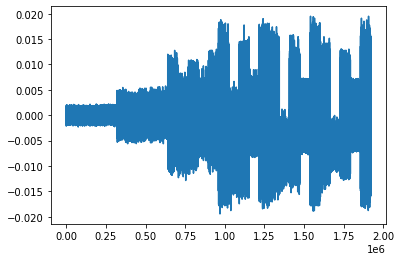

In [10]:
filename = 'data/dataset'
sigFile = sigmffile.fromfile(filename, skip_checksum=True)
annotations = sigFile.get_annotations()
nSignals = len(annotations)
nSamps = int(sigFile.sample_count/nSignals)
# The input data is a tensor with shape nSignals x 2 x nSamps
x = np.zeros((nSignals, 2, nSamps))
labels = np.array(['']*nSignals, dtype=object)
snrs = np.zeros((nSignals,))
plt.plot(sigFile.read_samples())
for iSignal, annotation in enumerate(annotations):
    # Label of the current signal
    labels[iSignal] = annotation[SigMFFile.LABEL_KEY]
    # Start index of the current signal
    annotationStart = annotation[SigMFFile.START_INDEX_KEY]
    # Length of the current signal in samples
    annotationLength = annotation[SigMFFile.LENGTH_INDEX_KEY]
    # Data for the current signal
    samples = sigFile.read_samples(annotationStart, annotationLength)
    snrs[iSignal] = float(annotation[detail.DETAIL_KEY][detail.SNR_KEY])
    # Store the signal data in the input tensor
    # Note: Since the data is complex, we need to split it into real and imaginary
    # parts because neural networks have trouble handling complex data
    x[iSignal, 0, :] = np.real(samples)
    x[iSignal, 1, :] = np.imag(samples)
# Number of unique signal classes
classes = np.unique(labels)


## Partition the data into training and testing sets


In [11]:
np.random.seed(0)
nTrain = int(0.5*nSignals)
nTest = nSignals - nTrain
# Since the input data is heavily structured, we need to shuffle the data to
# form the training and testing sets
trainIndex = np.random.permutation(range(0, nSignals))[0:nTrain]
# The test set is the complement of the training set
testIndex = list(set(range(0, nSignals)) - set(trainIndex))
# Generate the train/test examples/labels
xTrain = x[trainIndex, :, :]
xTest = x[testIndex, :, :]
labelTrain = labels[trainIndex]
labelTest = labels[testIndex]
inputShape = list(xTrain.shape[1:])
print(xTrain.shape)

(7500, 2, 128)


## Convert the class labels to one-hot vectors


In [12]:
def onehot(array):
  """
  Convert a list of labels to onehot representation
  """
  # Get the array of unique labels and the indices of the unique array that can
  # be used to reconstruct array
  unique, inverse = np.unique(array,return_inverse=True)
  # Each row of this identity matrix is the one-hot representation of each label
  # in unique, so we can get the one-hot encoding by choosing the corresponding
  # row for each index in inverse
  oneHot = np.eye(unique.shape[0])[inverse]
  return oneHot
yTrain = onehot(labelTrain)
yTest = onehot(labelTest)

## Build the model using Tensorflow


In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Build the model
#   - Reshape the [N,2,128] input to [N,1,2,128]
dropoutRate = 0.5
model = Sequential()
model.add(Reshape(inputShape+[1],
                  input_shape=inputShape))
model.add(ZeroPadding2D((2,0),
                        data_format='channels_first'))
model.add(Conv2D(256, (1, 3),
                 activation='relu',
                 padding='valid',
                 name='conv1'))
model.add(Dropout(dropoutRate))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(80, (2, 3),
                 padding='valid',
                 activation='relu',
                 name='conv2'))
model.add(Dropout(dropoutRate))
model.add(Flatten())
model.add(Dense(256,
                activation='relu', kernel_initializer='he_normal', name='dense1'))
model.add(Dropout(dropoutRate))
model.add(Dense(len(classes),
                kernel_initializer='he_normal', name='dense2'))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='Adam')
model.summary()

Num GPUs Available:  1
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, 2, 132, 1)        0         
 ng2D)                                                           
                                                                 
 conv1 (Conv2D)              (None, 2, 130, 256)       1024      
                                                                 
 dropout_6 (Dropout)         (None, 2, 130, 256)       0         
                                                                 
 zero_padding2d_5 (ZeroPaddi  (None, 2, 134, 256)      0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (N

## Train the model

In [14]:
nEpochs = 100
batchSize = 1024
history = model.fit(xTrain,yTrain,
                    batch_size=batchSize,
                    epochs=nEpochs,
                    validation_data=(xTest,yTest),
                    verbose=2,
                    callbacks = [
                      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto'),
                    ])

Epoch 1/100
8/8 - 1s - loss: 1.6016 - val_loss: 1.5751 - 943ms/epoch - 118ms/step
Epoch 2/100
8/8 - 1s - loss: 1.5325 - val_loss: 1.4742 - 548ms/epoch - 68ms/step
Epoch 3/100
8/8 - 1s - loss: 1.4450 - val_loss: 1.4095 - 544ms/epoch - 68ms/step
Epoch 4/100
8/8 - 1s - loss: 1.3923 - val_loss: 1.3918 - 526ms/epoch - 66ms/step
Epoch 5/100
8/8 - 1s - loss: 1.3651 - val_loss: 1.3419 - 532ms/epoch - 67ms/step
Epoch 6/100
8/8 - 1s - loss: 1.3254 - val_loss: 1.3103 - 551ms/epoch - 69ms/step
Epoch 7/100
8/8 - 1s - loss: 1.2874 - val_loss: 1.2676 - 549ms/epoch - 69ms/step
Epoch 8/100
8/8 - 1s - loss: 1.2471 - val_loss: 1.2428 - 567ms/epoch - 71ms/step
Epoch 9/100
8/8 - 1s - loss: 1.2236 - val_loss: 1.2042 - 532ms/epoch - 66ms/step
Epoch 10/100
8/8 - 1s - loss: 1.2118 - val_loss: 1.1737 - 548ms/epoch - 68ms/step
Epoch 11/100
8/8 - 1s - loss: 1.1633 - val_loss: 1.1288 - 570ms/epoch - 71ms/step
Epoch 12/100
8/8 - 1s - loss: 1.1294 - val_loss: 1.1801 - 540ms/epoch - 68ms/step
Epoch 13/100
8/8 - 1s - 

In [15]:
score = model.evaluate(xTest,yTest,verbose=0,batch_size=batchSize)
print(score)


0.7360341548919678
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d_6 (ZeroPaddi  (None, 2, 132, 1)        0         
 ng2D)                                                           
                                                                 
 conv1 (Conv2D)              (None, 2, 130, 256)       1024      
                                                                 
 dropout_9 (Dropout)         (None, 2, 130, 256)       0         
                                                                 
 zero_padding2d_7 (ZeroPaddi  (None, 2, 134, 256)      0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (None,

1.6094001531600952


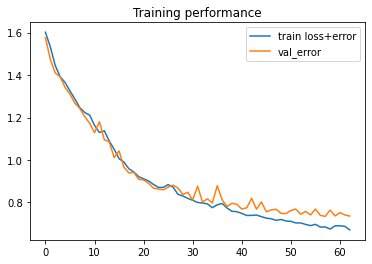

Text(0.5, 1.0, 'Confusion Matrix (full test set)')

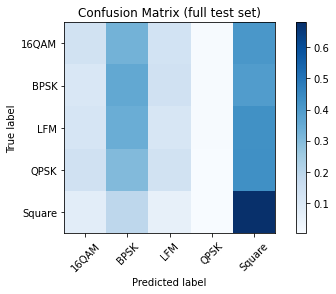

In [16]:

score = model.evaluate(xTest,yTest,verbose=0,batch_size=batchSize)
print(score)
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.show()

def confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='antialiased', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot confusion matrix
yPredTest = model.predict(xTest, batch_size=batchSize)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,xTest.shape[0]):
    j = list(yTest[i,:]).index(1)
    k = int(np.argmax(yPredTest[i,:]))
    conf[j,k] += 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
confusion_matrix(confnorm, labels=classes)
plt.title('Confusion Matrix (full test set)')

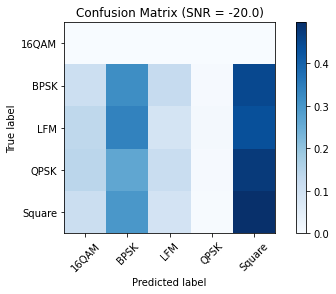

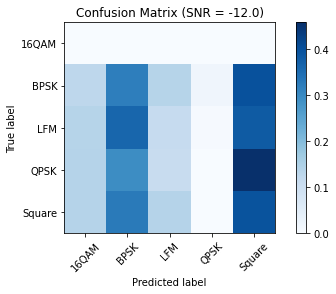

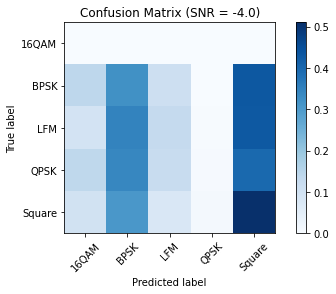

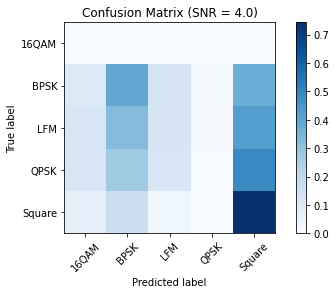

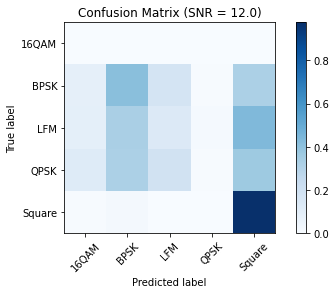

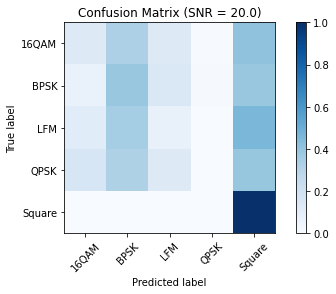

In [17]:
# Plot confusion matrix for various snrs
for snr in np.unique(snrs[testIndex]):
  xTestSnr = xTest[snrs[testIndex] == snr]
  yTestSnr = yTest[snrs[testIndex] == snr]
  yPredSnr = model.predict(xTestSnr, batch_size=batchSize)
  conf = np.zeros([len(classes),len(classes)])
  confnorm = np.zeros([len(classes),len(classes)])
  for i in range(0,xTestSnr.shape[0]):
      j = list(yTestSnr[i,:]).index(1)
      k = np.argmax(yPredSnr[i,:])
      conf[j,k] += 1
  for i in range(0,len(classes)):
      if np.sum(conf[i,:]) != 0:
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
  confusion_matrix(confnorm, labels=classes)
  plt.title(f'Confusion Matrix (SNR = {snr})')
  plt.show()